# **Deteksi Komentar Cyberbullying di Twitter Menggunakan IndoBERT**

## **Data Understanding**

In [ ]:
import pandas as pd

df = pd.read_excel('DATASET_CYBERBULLYING_TWITTER.xlsx')

In [3]:
df.head()

,No.,Nama Pelaku,Komentar,Kategori,Tanggal Posting,Nama Korban,Unnamed: 6,Unnamed: 7
0,1,@khanayarudinita,"""Makin jelek aja anaknya, padahal ibu ayahnya ...",Bullying,22 Juni 2019,@tasyakamila,NaN,NaN
1,2,@frdtias_,"""Jijik astagah sok bat cakep njs""",Bullying,28 Maret 2020,@eeericko,NaN,NaN
2,3,@belumadajudullagi,"""Kaya tulus ya mukanya klo diliat2""",Non-bullying,7 Maret 2021,@jeromepolin,NaN,NaN
3,4,@teukualmunawir,"""Jadi diri sendiri, jangan jadi ular apalagi d...",Bullying,18 Desember 2020,@rosameldianti_,NaN,NaN
4,5,@biankarachel,"""Aduuh.. terlalu halu.. hhahaha lebay editan n...",Bullying,7 Desember 2020,@rosameldianti_,NaN,NaN


In [4]:
df = df[['Komentar', 'Kategori']]
df.head()

,Komentar,Kategori
0,"""Makin jelek aja anaknya, padahal ibu ayahnya ...",Bullying
1,"""Jijik astagah sok bat cakep njs""",Bullying
2,"""Kaya tulus ya mukanya klo diliat2""",Non-bullying
3,"""Jadi diri sendiri, jangan jadi ular apalagi d...",Bullying
4,"""Aduuh.. terlalu halu.. hhahaha lebay editan n...",Bullying


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Komentar  650 non-null    object
 1   Kategori  650 non-null    object
dtypes: object(2)
memory usage: 10.3+ KB


In [6]:
df.duplicated().sum()

np.int64(0)

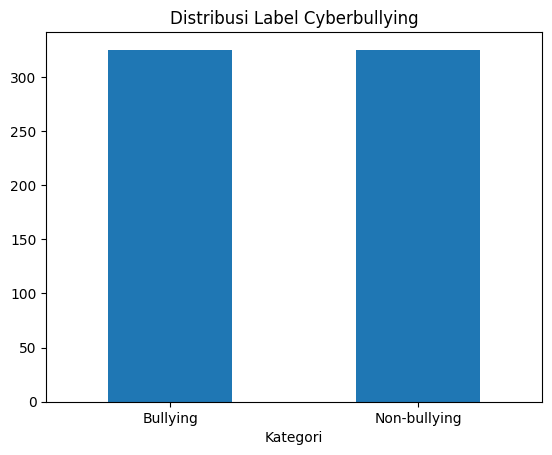

In [7]:
import matplotlib.pyplot as plt

df['Kategori'].value_counts().plot(kind='bar')
plt.title('Distribusi Label Cyberbullying')
plt.xticks(rotation=0)
plt.show()

## **Data Prepraration**

In [8]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.5 MB/s eta 0:00:00


In [9]:
import re
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
nltk.download('stopwords')

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower()

def stem_text(text):
    return stemmer.stem(text)

def preprocess_text(text):
    cleaned_text = clean_text(text)
    stemmed_text = stem_text(cleaned_text)

    stop_words = set(stopwords.words('indonesian'))
    stemmed_text = ' '.join([word for word in stemmed_text.split() if word not in stop_words])

    return stemmed_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
df['Preprocessed Komentar'] = df['Komentar'].apply(preprocess_text)

In [11]:
df

,Komentar,Kategori,Preprocessed Komentar
0,"""Makin jelek aja anaknya, padahal ibu ayahnya ...",Bullying,jelek aja anak ayah cakep
1,"""Jijik astagah sok bat cakep njs""",Bullying,jijik astagah sok bat cakep njs
2,"""Kaya tulus ya mukanya klo diliat2""",Non-bullying,kaya tulus ya muka klo liat
3,"""Jadi diri sendiri, jangan jadi ular apalagi d...",Bullying,ular dugong
4,"""Aduuh.. terlalu halu.. hhahaha lebay editan n...",Bullying,aduuh halu hhahaha lebay edit nyaa lemak lemak...
...,...,...,...
645,"""Frustasi..Sudah habis uangnya..Kasihannn""",Bullying,frustasi habis uang kasihannn
646,"""Tak sejelek IMAGE Owner ya..? Artis ups bukan...",Bullying,jelek image owner ya artis ups artis hallo lan...
647,"""Hati-hati mody jangan keluar sendirian jaga-j...",Non-bullying,hati hati mody jaga jaga serang brutal rasisme...
648,"""Lu sama anjingnya, lebih baik anjingnya""",Bullying,lu anjing anjing


In [12]:
dataset = df[['Preprocessed Komentar', 'Kategori']]
dataset.columns = ['text', 'label']

In [13]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
dataset['label'] = label_encoder.fit_transform(dataset['label'])

<ipython-input-13-a9fb4c9c35ce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['label'] = label_encoder.fit_transform(dataset['label'])


In [14]:
dataset.head()

,text,label
0,jelek aja anak ayah cakep,0
1,jijik astagah sok bat cakep njs,0
2,kaya tulus ya muka klo liat,1
3,ular dugong,0
4,aduuh halu hhahaha lebay edit nyaa lemak lemak...,0


## **Modeling**

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

In [16]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(
    dataset['text'].tolist(), dataset['label'].tolist(), test_size=0.2, random_state=42
)

In [17]:
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [19]:
train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels}).map(tokenize, batched=True)
test_dataset = Dataset.from_dict({'text': test_texts, 'label': test_labels}).map(tokenize, batched=True)

Map:   0%|          | 0/520 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/130 [00:00<?, ? examples/s]

In [20]:
training_args = TrainingArguments(
    output_dir="./results", eval_strategy="epoch", per_device_train_batch_size=8,
    per_device_eval_batch_size=8, num_train_epochs=3, weight_decay=0.01, logging_dir='./logs'
)

In [21]:
trainer = Trainer(model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset)
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 2210631170104 (cintarenita-universitas-singaperbangsa-karawang) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.429688
2,No log,0.525391
3,No log,0.622501


TrainOutput(global_step=195, training_loss=0.2246878208258213, metrics={'train_runtime': 963.0876, 'train_samples_per_second': 1.62, 'train_steps_per_second': 0.202, 'total_flos': 27256660891200.0, 'train_loss': 0.2246878208258213, 'epoch': 3.0})

## **Evaluation**

In [23]:
import numpy as np
from sklearn.metrics import classification_report

preds = trainer.predict(test_dataset)
y_pred = np.argmax(preds.predictions, axis=1)

print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        66
           1       0.90      0.86      0.88        64

    accuracy                           0.88       130
   macro avg       0.89      0.88      0.88       130
weighted avg       0.89      0.88      0.88       130



In [27]:
model.save_pretrained("cyberbullying_model")

In [28]:
tokenizer.save_pretrained("cyberbullying_tokenizer")

('cyberbullying_tokenizer/tokenizer_config.json',
 'cyberbullying_tokenizer/special_tokens_map.json',
 'cyberbullying_tokenizer/vocab.txt',
 'cyberbullying_tokenizer/added_tokens.json',
 'cyberbullying_tokenizer/tokenizer.json')

In [32]:
# prompt: download folder cyberbullying_model

!zip -r /content/cyberbullying_model.zip /content/cyberbullying_model
from google.colab import files
files.download('/content/cyberbullying_model.zip')

updating: content/cyberbullying_model/ (stored 0%)
updating: content/cyberbullying_model/config.json (deflated 55%)
updating: content/cyberbullying_model/model.safetensors (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
# prompt: download folder cyberbullying_model

!zip -r /content/cyberbullying_tokenizer.zip /content/cyberbullying_tokenizer
from google.colab import files
files.download('/content/cyberbullying_tokenizer.zip')

  adding: content/cyberbullying_tokenizer/ (stored 0%)
  adding: content/cyberbullying_tokenizer/tokenizer.json (deflated 71%)
  adding: content/cyberbullying_tokenizer/vocab.txt (deflated 53%)
  adding: content/cyberbullying_tokenizer/special_tokens_map.json (deflated 42%)
  adding: content/cyberbullying_tokenizer/tokenizer_config.json (deflated 74%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>